In [99]:
# Load libraries
import pandas as pd
import numpy as np
import json
import tensorflow as tf
from sklearn import model_selection
import networkx as nx

import sys
# import osa
import torch
import argparse
import random


import stellargraph as sg
from stellargraph.mapper import GraphSAGELinkGenerator, GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UnsupervisedSampler


#Hindsage libraries
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('yelp_academic_dataset_review.json') as json_file:      
    data = json_file.readlines()
    # this line below may take at least 8-10 minutes of processing for 4-5 million rows. It converts all strings in list to actual json objects. 
    data = list(map(json.loads, data)) 
reviews_data = pd.DataFrame(data)

In [3]:
with open('yelp_academic_dataset_user.json') as json_file_1:      
    data_1 = json_file_1.readlines()
    # this line below may take at least 8-10 minutes of processing for 4-5 million rows. It converts all strings in list to actual json objects. 
    data_1 = list(map(json.loads, data_1)) 

user_data = pd.DataFrame(data_1)

In [4]:
with open('yelp_academic_dataset_business.json') as json_file_2:      
    data_2 = json_file_2.readlines()
    # this line below may take at least 8-10 minutes of processing for 4-5 million rows. It converts all strings in list to actual json objects. 
    data_2 = list(map(json.loads, data_2)) 

business_data = pd.DataFrame(data_2)

In [5]:
business_dataset = business_data[business_data.state == 'IL']

In [6]:
business_dataset = business_dataset.loc[(business_dataset['review_count'] >= 15)]

In [7]:
business_dataset.index = pd.Series(range(0,717))

In [8]:
node_data_business = pd.DataFrame(business_dataset)
feature_names_business = ['business_id','stars']
node_features_business = pd.DataFrame(node_data_business[feature_names_business],index = node_data_business.index)
node_features_business.index =  node_data_business["business_id"]
node_features_business = node_features_business.drop(columns=['business_id'])
node_features_business[0:]

,stars
business_id,
UiyjUa8CQmygujhe-ZYlsw,3.0
-LfTBo0oa_uD454ScEW2XA,3.0
R32Yh0XxxanldkIp11fuRg,3.5
-1TUzO4XCmOeqi9eAGeDWA,4.5
WO2nNar_wIQ3fIAfF3MM1Q,4.0
...,...
ldKrUirpZZ6JDnNwOwLpvw,3.0
KCQNEIvtU48Mh07uS-_Gvw,2.5
nh1-ax9wPNCqskcJYIWogg,2.5


In [9]:
# Data cleaning for reviews dataset

In [10]:
business_id_array = business_dataset['business_id'].values

In [11]:
reviews_dataset = reviews_data.loc[reviews_data['business_id'].isin(business_id_array)]

In [12]:
reviews_dataset.index = pd.Series(range(0,39138))
node_data_review = pd.DataFrame(reviews_dataset)
feature_names_reviews = ['review_id','stars']
node_features_reviews = pd.DataFrame(node_data_review[feature_names_reviews],index = node_data_review.index)
node_features_reviews.index = node_data_review['review_id']
node_features_reviews = node_features_reviews.drop(columns = ['review_id'])
node_features_reviews[0:]

,stars
review_id,
qWHp2l2lysENZObh6MAulA,5.0
n2BEHit2SwqsRo6jlTagUA,2.0
m4AXzV9l14iFBd9DRdM82w,1.0
A-yKlSLEQQcoHR5q2lCyHg,5.0
asLnux3k2yqoVjcJcLuF0g,4.0
...,...
57cCUwZm4lsHum8aENC6Kg,1.0
ZnE93UGlk29kX0dfwMOGNw,5.0
fGgMD8npNcGyx_Fr91m_Dg,4.0


In [13]:
#Data cleaning for user dataset

In [14]:
user_id_array = reviews_dataset['user_id'].values

In [15]:
user_dataset = user_data.loc[user_data['user_id'].isin(user_id_array)]

In [16]:
user_dataset.index = pd.Series(range(0,14664))
node_data_user = pd.DataFrame(user_dataset)
feature_names_user = ['user_id']
node_features_user = pd.DataFrame(node_data_user[feature_names_user],index = node_data_user.index)
node_features_user[0:]

,user_id
0,fcNU65OaCj7slBJ60VSQgw
1,4mjnkd8oJVCfBKN3i4rB-g
2,ZdYHJ-hctaaDeH1CpP7-EA
3,JWgti_adPZywG9SKUbnB-w
4,PIzmdHF7p9GwXhwt3b3JxQ
...,...
14659,YfVGrr7SqPI1NY-mx9jfUw
14660,lcd1uiaw4sZd7wGxpHbd0w
14661,woRHA_rBPcg-KU8EJDG1Ig
14662,3Xop9LVQDOWIVjFRj07QTw


In [17]:
node_features_user["ratings"] = 0.0

In [18]:
node_features_user["ratings_count"] = 0.0
node_features_user["stars"] = 0.0

In [19]:
node_features_user[0:]

,user_id,ratings,ratings_count,stars
0,fcNU65OaCj7slBJ60VSQgw,0.0,0.0,0.0
1,4mjnkd8oJVCfBKN3i4rB-g,0.0,0.0,0.0
2,ZdYHJ-hctaaDeH1CpP7-EA,0.0,0.0,0.0
3,JWgti_adPZywG9SKUbnB-w,0.0,0.0,0.0
4,PIzmdHF7p9GwXhwt3b3JxQ,0.0,0.0,0.0
...,...,...,...,...
14659,YfVGrr7SqPI1NY-mx9jfUw,0.0,0.0,0.0
14660,lcd1uiaw4sZd7wGxpHbd0w,0.0,0.0,0.0
14661,woRHA_rBPcg-KU8EJDG1Ig,0.0,0.0,0.0
14662,3Xop9LVQDOWIVjFRj07QTw,0.0,0.0,0.0


In [20]:
# node_features_user.index = node_features_user['user_id']

In [21]:
# print(reviews_dataset.iloc[[-1]]['user_id'])
# c = reviews_dataset.iloc[[-1]]['user_id']
# print("val",c.keys)
# print(node_features_user.loc[[c.values[0]]]['stars']+1)


In [22]:
reviews_dataset

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,qWHp2l2lysENZObh6MAulA,5lb0POg2t-AkMFx6603cYQ,ZlCSsWS07JulSBIQlrbF5w,5.0,1,0,0,Called for a 5:15 morning reservation. The dri...,2015-05-26 10:36:47
1,n2BEHit2SwqsRo6jlTagUA,abdw-Nf5xxWdi5wmUO7UYg,2qLOnQtWSlTOtkfEFyWScg,2.0,2,0,0,"There are good things, and bad things about th...",2013-04-10 19:26:54
2,m4AXzV9l14iFBd9DRdM82w,6X0i-oGUbh5DZdTHzFuKfg,9A1C1f0m4nQltQrOOTl-Kw,1.0,11,1,0,The building is lovely. The remodel after But...,2013-12-07 02:26:13
3,A-yKlSLEQQcoHR5q2lCyHg,Yximlvn0cfb3yVDaLuXDxw,VHsNB3pdGVcRgs6C3jt6Zg,5.0,1,0,0,LOVE LOVE LOVE this place! I'm a bit of a suck...,2013-08-03 19:59:56
4,asLnux3k2yqoVjcJcLuF0g,Cz8l7JQ2I_RhtK0BosH-7Q,Ah4i15g8Ow_zphzcpulTxQ,4.0,0,0,0,The bread company is perfect for lunch. The pr...,2015-12-05 05:38:55
...,...,...,...,...,...,...,...,...,...
39133,57cCUwZm4lsHum8aENC6Kg,R_VuCujoBAOFpUuqIYC_Gg,IJ_1Hcuh89ETzDFK6pXOpg,1.0,0,0,0,Came here to do my laundry at 8:00 on a Sunday...,2019-12-09 02:38:18
39134,ZnE93UGlk29kX0dfwMOGNw,ViqyzZgObMSOwWBoQbLjSg,PBmfdx-tC2D54FI3HtcKww,5.0,0,0,0,Have always loved The Ribeye. The best salad ...,2019-11-26 00:20:28
39135,fGgMD8npNcGyx_Fr91m_Dg,Nl9ouJ9EqcNCX7gdPw9ZCw,dn9lwYUxmhs_mLKPu7L25Q,4.0,0,0,0,The appetizers and my seared tuna were awesome!,2014-02-17 12:39:26
39136,flX4YICNgGSs2QriJ2CgRw,x4XrrBXlKABQCyv1AMHHrA,l4x5FFzfiCFrGN0S-uZbBQ,4.0,0,0,0,"Came to dinner on a Tuesday night and, granted...",2019-10-23 15:04:57


In [23]:
for i in range(reviews_dataset.shape[0]):
    row = reviews_dataset.iloc[i]
    feature = node_features_user.loc[node_features_user['user_id'] == row['user_id']]
    index = feature.index
    node_features_user['ratings'][index] += row['stars']
    node_features_user['ratings_count'][index] += 1



<ipython-input-23-5d4c08f878bd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_features_user['ratings'][index] += row['stars']
<ipython-input-23-5d4c08f878bd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_features_user['ratings_count'][index] += 1


In [24]:
node_features_user[0:]

,user_id,ratings,ratings_count,stars
0,fcNU65OaCj7slBJ60VSQgw,2.0,2.0,0.0
1,4mjnkd8oJVCfBKN3i4rB-g,90.0,26.0,0.0
2,ZdYHJ-hctaaDeH1CpP7-EA,27.0,7.0,0.0
3,JWgti_adPZywG9SKUbnB-w,5.0,1.0,0.0
4,PIzmdHF7p9GwXhwt3b3JxQ,5.0,2.0,0.0
...,...,...,...,...
14659,YfVGrr7SqPI1NY-mx9jfUw,5.0,1.0,0.0
14660,lcd1uiaw4sZd7wGxpHbd0w,5.0,1.0,0.0
14661,woRHA_rBPcg-KU8EJDG1Ig,4.0,1.0,0.0
14662,3Xop9LVQDOWIVjFRj07QTw,1.0,1.0,0.0


In [25]:
for j in range(node_features_user.shape[0]):
    node_features_user['stars'][j] = node_features_user['ratings'][j] / node_features_user['ratings_count'][j]

<ipython-input-25-cb882bdf2f52>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_features_user['stars'][j] = node_features_user['ratings'][j] / node_features_user['ratings_count'][j]


In [26]:
node_features_user[0:]

,user_id,ratings,ratings_count,stars
0,fcNU65OaCj7slBJ60VSQgw,2.0,2.0,1.000000
1,4mjnkd8oJVCfBKN3i4rB-g,90.0,26.0,3.461538
2,ZdYHJ-hctaaDeH1CpP7-EA,27.0,7.0,3.857143
3,JWgti_adPZywG9SKUbnB-w,5.0,1.0,5.000000
4,PIzmdHF7p9GwXhwt3b3JxQ,5.0,2.0,2.500000
...,...,...,...,...
14659,YfVGrr7SqPI1NY-mx9jfUw,5.0,1.0,5.000000
14660,lcd1uiaw4sZd7wGxpHbd0w,5.0,1.0,5.000000
14661,woRHA_rBPcg-KU8EJDG1Ig,4.0,1.0,4.000000
14662,3Xop9LVQDOWIVjFRj07QTw,1.0,1.0,1.000000


In [27]:
node_features_user.index = node_features_user['user_id']
node_features_user = node_features_user.drop(columns = ['user_id','ratings','ratings_count'])

In [28]:
node_features_user[0:]

,stars
user_id,
fcNU65OaCj7slBJ60VSQgw,1.000000
4mjnkd8oJVCfBKN3i4rB-g,3.461538
ZdYHJ-hctaaDeH1CpP7-EA,3.857143
JWgti_adPZywG9SKUbnB-w,5.000000
PIzmdHF7p9GwXhwt3b3JxQ,2.500000
...,...
YfVGrr7SqPI1NY-mx9jfUw,5.000000
lcd1uiaw4sZd7wGxpHbd0w,5.000000
woRHA_rBPcg-KU8EJDG1Ig,4.000000


In [29]:
#Hindsage
batch_size = 200
epochs = 20
# Use 70% of edges for training, the rest for testing:
train_size = 0.7
test_size = 0.3

In [30]:
review_business_edges = pd.DataFrame({"source": reviews_dataset['review_id'],
                                      "target": reviews_dataset['business_id'],
                                      "weight":reviews_dataset['stars']})

review_user_edges = pd.DataFrame({"source": reviews_dataset['user_id'],
                                      "target": reviews_dataset['review_id'],
                                      "weight":reviews_dataset['stars']})

user_business_edges = pd.DataFrame({"source": reviews_dataset['user_id'],
                                      "target": reviews_dataset['business_id'],
                                      "weight":reviews_dataset['stars']})
user_business_edges

,source,target,weight
0,5lb0POg2t-AkMFx6603cYQ,ZlCSsWS07JulSBIQlrbF5w,5.0
1,abdw-Nf5xxWdi5wmUO7UYg,2qLOnQtWSlTOtkfEFyWScg,2.0
2,6X0i-oGUbh5DZdTHzFuKfg,9A1C1f0m4nQltQrOOTl-Kw,1.0
3,Yximlvn0cfb3yVDaLuXDxw,VHsNB3pdGVcRgs6C3jt6Zg,5.0
4,Cz8l7JQ2I_RhtK0BosH-7Q,Ah4i15g8Ow_zphzcpulTxQ,4.0
...,...,...,...
39133,R_VuCujoBAOFpUuqIYC_Gg,IJ_1Hcuh89ETzDFK6pXOpg,1.0
39134,ViqyzZgObMSOwWBoQbLjSg,PBmfdx-tC2D54FI3HtcKww,5.0
39135,Nl9ouJ9EqcNCX7gdPw9ZCw,dn9lwYUxmhs_mLKPu7L25Q,4.0
39136,x4XrrBXlKABQCyv1AMHHrA,l4x5FFzfiCFrGN0S-uZbBQ,4.0


In [31]:
# edges.index = pd.Series(range(0,117414))
# edges

In [32]:
edges_train, edges_test = model_selection.train_test_split(
    user_business_edges, train_size=train_size, test_size=test_size
)

edgelist_train = list(edges_train[["source", "target"]].itertuples(index=False))
edgelist_test = list(edges_test[["source", "target"]].itertuples(index=False))

labels_train = edges_train["weight"]
labels_test = edges_test["weight"]

In [33]:
num_samples = [8, 4]

In [34]:
#To find the duplicates in features data frame
# pics = features.index.unique()
# len(pics)
# for i in (pics):
#     sub = features[features.index==i]
#     if len(sub)>1:
#         print(sub)  

In [35]:
features = pd.concat([node_features_reviews,node_features_business,node_features_user])

In [36]:
G = sg.StellarGraph(nodes = {"user": node_features_user,"business": node_features_business}, edges = user_business_edges)

In [37]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 15381, Edges: 39138

 Node types:
  user: [14664]
    Features: float32 vector, length 1
    Edge types: user-default->business
  business: [717]
    Features: float32 vector, length 1
    Edge types: business-default->user

 Edge types:
    business-default->user: [39138]
        Weights: range=[1, 5], mean=3.58421, std=1.4602
        Features: none


In [38]:
# generator_G = GraphSAGELinkGenerator(G, batch_size, num_samples)
# train_gen_G = generator.flow(edgelist_train, labels_train, shuffle=True)
# test_gen_G = generator.flow(edgelist_test, labels_test)

In [39]:
nodes_user = list(node_features_user.index)
nodes_business = list(node_features_business.index)
nodes = nodes_user + nodes_business
number_of_walks = 1
length = 5

In [40]:
generator = sg.mapper.HinSAGELinkGenerator(
    G, batch_size, num_samples , head_node_types = ('user','business')
)

In [41]:
train_gen = generator.flow(edgelist_train, labels_train, shuffle=True)

In [42]:
test_gen = generator.flow(edgelist_test, labels_test)

In [43]:
generator.schema.type_adjacency_list(generator.head_node_types, len(num_samples))

[('user', [2]),
 ('business', [3]),
 ('business', [4]),
 ('user', [5]),
 ('user', []),
 ('business', [])]

In [44]:
generator.schema.schema

{'user': [EdgeType(n1='user', rel='default', n2='business')],
 'business': [EdgeType(n1='business', rel='default', n2='user')]}

In [45]:
hinsage_layer_sizes = [32, 32]
assert len(hinsage_layer_sizes) == len(num_samples)

hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes, generator=generator, bias=True, dropout=0.0
)

In [46]:
x_inp, x_out = hinsage.in_out_tensors()

In [47]:
score_prediction = link_regression(edge_embedding_method="concat")(x_out)

link_regression: using 'concat' method to combine node embeddings into edge embeddings


In [48]:
x_inp

[<KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 8, 1) dtype=float32 (created by layer 'input_3')>,
 <KerasTensor: shape=(None, 8, 1) dtype=float32 (created by layer 'input_4')>,
 <KerasTensor: shape=(None, 32, 1) dtype=float32 (created by layer 'input_5')>,
 <KerasTensor: shape=(None, 32, 1) dtype=float32 (created by layer 'input_6')>]

In [49]:
x_out

[<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'lambda')>,
 <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'lambda')>]

In [50]:
score_prediction

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'reshape_8')>

In [51]:
import tensorflow.keras.backend as K


def root_mean_square_error(s_true, s_pred):
    return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))


model = Model(inputs=x_inp, outputs=score_prediction)
model.compile(
    optimizer=optimizers.Adam(lr=1e-2),
    loss=losses.mean_squared_error,
    metrics=[root_mean_square_error, metrics.mae],
)

In [52]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 8, 1)]       0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 32, 1)]      0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 32, 1)]      0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1, 1)]       0                                            
______________________________________________________________________________________________

In [53]:
num_workers = 4

In [54]:
test_metrics = model.evaluate(
    test_gen, verbose=1, use_multiprocessing=False, workers=num_workers
)

print("Untrained model's Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

59/59 [==============================] - 7s 81ms/step - loss: 13.3443 - root_mean_square_error: 3.6521 - mean_absolute_error: 3.3483: 2s - loss: 13.3415 - root_mean_square_error: 3.6517 - mean_absolu
Untrained model's Test Evaluation:
	loss: 13.3494
	root_mean_square_error: 3.6534
	mean_absolute_error: 3.3485


In [55]:
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    workers=num_workers,
)

Epoch 1/20
137/137 [==============================] - 19s 118ms/step - loss: 1.9679 - root_mean_square_error: 1.3353 - mean_absolute_error: 1.1288 - val_loss: 0.9609 - val_root_mean_square_error: 0.9785 - val_mean_absolute_error: 0.7345 4.0688 - root_mean_square_error: 1.9270 - mean_absolu - ETA - ETA: 3s - loss: 2.4541  - ETA: 0s - loss: 2.0452 - root_mean_square_error: 1.3617 - mean_absolute_error: 1.
Epoch 2/20
137/137 [==============================] - 17s 120ms/step - loss: 0.9465 - root_mean_square_error: 0.9707 - mean_absolute_error: 0.7237 - val_loss: 0.8712 - val_root_mean_square_error: 0.9314 - val_mean_absolute_error: 0.68351.0046 - root_mean_square_error:  - ETA: 6s - l - ETA: 3s - loss: 0.9605 - root_mean_square_error: 0.9777 - mean_absolu - ETA: 2s - loss: 0.9578 - root_mean_square_error: 0.9764 - mean_absolute_error: 0.72 - ETA: 2s - loss: 0.9580 - root_mean_square_error: 0.9765 - mean_absolu - ETA: 1s - loss: 0.9517 - root_mean_square_error: 0.9733 - mean_absolute_err -

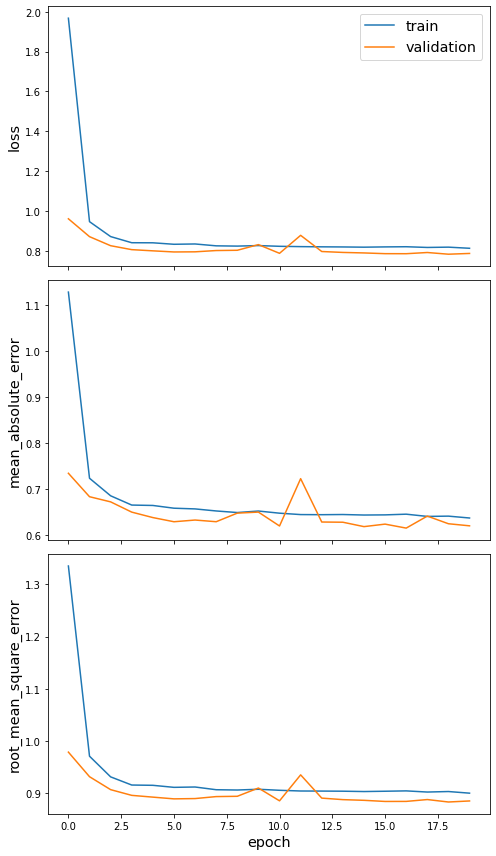

In [56]:
sg.utils.plot_history(history)

In [57]:
test_metrics = model.evaluate(
    test_gen, use_multiprocessing=False, workers=num_workers, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

59/59 [==============================] - 5s 72ms/step - loss: 0.7842 - root_mean_square_error: 0.8832 - mean_absolute_error: 0.6188 5s - loss: 0.7383 - root_mean_square_error: 0.8583 - - ETA: 2s - loss: 0.8017 - root_mean_square_error: 0.8937 - mean_absolute_error: 0. - ETA: 2s - loss: 0.8025 - root_mean_square_error: 0.89 - ETA: 1s - loss: 0.7790 - root_mean_square_error: 0.8806 - mean_absolute_error
Test Evaluation:
	loss: 0.7842
	root_mean_square_error: 0.8832
	mean_absolute_error: 0.6188


In [58]:
y_true = labels_test
# Predict the rankings using the model:
y_pred = model.predict(test_gen)
# Mean baseline rankings = mean movie ranking:
y_pred_baseline = np.full_like(y_pred, np.mean(y_true))

rmse = np.sqrt(mean_squared_error(y_true, y_pred_baseline))
mae = mean_absolute_error(y_true, y_pred_baseline)
print("Mean Baseline Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

Mean Baseline Test set metrics:
	root_mean_square_error =  1.4579314691033447
	mean_absolute_error =  1.2689980468074258

Model Test set metrics:
	root_mean_square_error =  0.8831213228134993
	mean_absolute_error =  0.6176859010648654


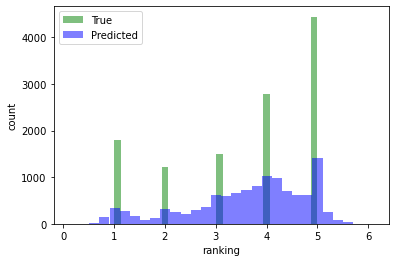

In [59]:
h_true = plt.hist(y_true, bins=30, facecolor="green", alpha=0.5)
h_pred = plt.hist(y_pred, bins=30, facecolor="blue", alpha=0.5)
plt.xlabel("ranking")
plt.ylabel("count")
plt.legend(("True", "Predicted"))
plt.show()

In [60]:
#Implementation of SVM

In [61]:
from sklearn import svm

In [62]:
reviews_dataset

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,qWHp2l2lysENZObh6MAulA,5lb0POg2t-AkMFx6603cYQ,ZlCSsWS07JulSBIQlrbF5w,5.0,1,0,0,Called for a 5:15 morning reservation. The dri...,2015-05-26 10:36:47
1,n2BEHit2SwqsRo6jlTagUA,abdw-Nf5xxWdi5wmUO7UYg,2qLOnQtWSlTOtkfEFyWScg,2.0,2,0,0,"There are good things, and bad things about th...",2013-04-10 19:26:54
2,m4AXzV9l14iFBd9DRdM82w,6X0i-oGUbh5DZdTHzFuKfg,9A1C1f0m4nQltQrOOTl-Kw,1.0,11,1,0,The building is lovely. The remodel after But...,2013-12-07 02:26:13
3,A-yKlSLEQQcoHR5q2lCyHg,Yximlvn0cfb3yVDaLuXDxw,VHsNB3pdGVcRgs6C3jt6Zg,5.0,1,0,0,LOVE LOVE LOVE this place! I'm a bit of a suck...,2013-08-03 19:59:56
4,asLnux3k2yqoVjcJcLuF0g,Cz8l7JQ2I_RhtK0BosH-7Q,Ah4i15g8Ow_zphzcpulTxQ,4.0,0,0,0,The bread company is perfect for lunch. The pr...,2015-12-05 05:38:55
...,...,...,...,...,...,...,...,...,...
39133,57cCUwZm4lsHum8aENC6Kg,R_VuCujoBAOFpUuqIYC_Gg,IJ_1Hcuh89ETzDFK6pXOpg,1.0,0,0,0,Came here to do my laundry at 8:00 on a Sunday...,2019-12-09 02:38:18
39134,ZnE93UGlk29kX0dfwMOGNw,ViqyzZgObMSOwWBoQbLjSg,PBmfdx-tC2D54FI3HtcKww,5.0,0,0,0,Have always loved The Ribeye. The best salad ...,2019-11-26 00:20:28
39135,fGgMD8npNcGyx_Fr91m_Dg,Nl9ouJ9EqcNCX7gdPw9ZCw,dn9lwYUxmhs_mLKPu7L25Q,4.0,0,0,0,The appetizers and my seared tuna were awesome!,2014-02-17 12:39:26
39136,flX4YICNgGSs2QriJ2CgRw,x4XrrBXlKABQCyv1AMHHrA,l4x5FFzfiCFrGN0S-uZbBQ,4.0,0,0,0,"Came to dinner on a Tuesday night and, granted...",2019-10-23 15:04:57


In [63]:
user_dataset

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,fcNU65OaCj7slBJ60VSQgw,Steven,1204,2007-07-08 16:56:40,4907,2674,2718,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2016","T-CVPEYAAJFWGzXaxSt8eg, zyhHd6AeavKVdOAXAPz-DQ...",89,...,14,12,6,4,79,141,183,183,57,12
1,4mjnkd8oJVCfBKN3i4rB-g,Tricia,1247,2008-11-27 02:24:47,3967,2631,2491,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2018","RO3vznPVVw5NWcgfP3k17A, azPMZoWkxdyjpnFul3aBQw...",141,...,26,25,15,10,127,236,227,227,124,102
2,ZdYHJ-hctaaDeH1CpP7-EA,Colleen,266,2009-08-08 16:46:46,491,103,152,"2010,2011,2012,2013,2014","ouODopBKF3AqfCkuQEnrDg, QowYhZNL0T3UOi1FLG5VYQ...",11,...,4,2,3,0,14,16,17,17,5,3
3,JWgti_adPZywG9SKUbnB-w,Sarah,141,2007-11-12 02:56:43,227,76,42,2015,"-X2qJ65I4Gz3UznpJqqS7Q, XrrXU5whFrQo_3wpiKhpaw...",1,...,2,0,0,0,5,3,5,5,2,1
4,PIzmdHF7p9GwXhwt3b3JxQ,Sasuke,112,2008-07-15 19:06:06,154,57,35,,"wPkrThYsvs-pii7Ac1Hk9w, nO4bSABjYmR3MVvVjC0EeQ...",7,...,3,0,0,0,3,4,1,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14659,YfVGrr7SqPI1NY-mx9jfUw,Liz,2,2018-03-19 22:18:34,0,0,0,,None,0,...,0,0,0,0,0,0,0,0,0,0
14660,lcd1uiaw4sZd7wGxpHbd0w,Lisa,3,2014-08-03 22:23:27,4,1,0,,None,0,...,0,0,0,0,0,0,0,0,0,0
14661,woRHA_rBPcg-KU8EJDG1Ig,Gloria,17,2016-03-05 03:55:54,0,0,0,,None,0,...,0,0,0,0,0,0,0,0,0,0
14662,3Xop9LVQDOWIVjFRj07QTw,Boom Your Place Sucks,2,2014-10-09 07:16:34,5,5,2,,None,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
user_dataset['stars'] = 0

<ipython-input-64-2bc9ba5bffb9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_dataset['stars'] = 0


In [65]:
features_copy = node_features_user.copy()
features_copy

,stars
user_id,
fcNU65OaCj7slBJ60VSQgw,1.000000
4mjnkd8oJVCfBKN3i4rB-g,3.461538
ZdYHJ-hctaaDeH1CpP7-EA,3.857143
JWgti_adPZywG9SKUbnB-w,5.000000
PIzmdHF7p9GwXhwt3b3JxQ,2.500000
...,...
YfVGrr7SqPI1NY-mx9jfUw,5.000000
lcd1uiaw4sZd7wGxpHbd0w,5.000000
woRHA_rBPcg-KU8EJDG1Ig,4.000000


In [66]:
features_copy.index = pd.Series(range(0,14664))

In [67]:
for j in range(user_dataset.shape[0]):
    user_dataset['stars'][j] = node_features_user['stars'][j]

<ipython-input-67-6cfbcf6bac89>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_dataset['stars'][j] = node_features_user['stars'][j]
/Applications/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [68]:
user_dataset[0:]

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,stars
0,fcNU65OaCj7slBJ60VSQgw,Steven,1204,2007-07-08 16:56:40,4907,2674,2718,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2016","T-CVPEYAAJFWGzXaxSt8eg, zyhHd6AeavKVdOAXAPz-DQ...",89,...,12,6,4,79,141,183,183,57,12,1
1,4mjnkd8oJVCfBKN3i4rB-g,Tricia,1247,2008-11-27 02:24:47,3967,2631,2491,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2018","RO3vznPVVw5NWcgfP3k17A, azPMZoWkxdyjpnFul3aBQw...",141,...,25,15,10,127,236,227,227,124,102,3
2,ZdYHJ-hctaaDeH1CpP7-EA,Colleen,266,2009-08-08 16:46:46,491,103,152,"2010,2011,2012,2013,2014","ouODopBKF3AqfCkuQEnrDg, QowYhZNL0T3UOi1FLG5VYQ...",11,...,2,3,0,14,16,17,17,5,3,3
3,JWgti_adPZywG9SKUbnB-w,Sarah,141,2007-11-12 02:56:43,227,76,42,2015,"-X2qJ65I4Gz3UznpJqqS7Q, XrrXU5whFrQo_3wpiKhpaw...",1,...,0,0,0,5,3,5,5,2,1,5
4,PIzmdHF7p9GwXhwt3b3JxQ,Sasuke,112,2008-07-15 19:06:06,154,57,35,,"wPkrThYsvs-pii7Ac1Hk9w, nO4bSABjYmR3MVvVjC0EeQ...",7,...,0,0,0,3,4,1,1,4,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14659,YfVGrr7SqPI1NY-mx9jfUw,Liz,2,2018-03-19 22:18:34,0,0,0,,None,0,...,0,0,0,0,0,0,0,0,0,5
14660,lcd1uiaw4sZd7wGxpHbd0w,Lisa,3,2014-08-03 22:23:27,4,1,0,,None,0,...,0,0,0,0,0,0,0,0,0,5
14661,woRHA_rBPcg-KU8EJDG1Ig,Gloria,17,2016-03-05 03:55:54,0,0,0,,None,0,...,0,0,0,0,0,0,0,0,0,4
14662,3Xop9LVQDOWIVjFRj07QTw,Boom Your Place Sucks,2,2014-10-09 07:16:34,5,5,2,,None,0,...,0,0,0,0,0,0,0,0,0,1


In [69]:
business_dataset

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,UiyjUa8CQmygujhe-ZYlsw,Movers 4 Less Inc,,Champaign,IL,61822,40.127030,-88.241699,3.0,15,1,"{'BusinessAcceptsCreditCards': 'True', 'Busine...","Home Services, Movers","{'Monday': '8:0-20:0', 'Tuesday': '8:0-20:0', ..."
1,-LfTBo0oa_uD454ScEW2XA,Merry Ann's Diner,1 E Main St,Champaign,IL,61820,40.118133,-88.242900,3.0,47,0,"{'RestaurantsDelivery': 'True', 'WiFi': 'u'fre...","Restaurants, Diners, Sandwiches, Breakfast & B...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
2,R32Yh0XxxanldkIp11fuRg,BoBo's BBQ,1511 W Springfield Ave,Champaign,IL,61821,40.112515,-88.271575,3.5,45,1,"{'RestaurantsAttire': 'u'casual'', 'Restaurant...","Hot Dogs, Restaurants, Barbeque","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'..."
3,-1TUzO4XCmOeqi9eAGeDWA,Beaumont Tire & Auto Repair,1202 W Bloomington Rd,Champaign,IL,61821,40.136060,-88.266079,4.5,15,1,{'BusinessAcceptsCreditCards': 'True'},"Auto Repair, Automotive, Tires","{'Monday': '8:0-17:30', 'Tuesday': '8:0-17:30'..."
4,WO2nNar_wIQ3fIAfF3MM1Q,Exile on Main Street,"116 N Chestnut St, Ste 120",Champaign,IL,61820,40.116715,-88.240606,4.0,24,1,"{'BusinessAcceptsBitcoin': 'False', 'BusinessP...","Newspapers & Magazines, Books, Mags, Music & V...","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,ldKrUirpZZ6JDnNwOwLpvw,Ichiban Buffet,105 N Mattis Ave,Champaign,IL,61821,40.117048,-88.278364,3.0,35,0,"{'GoodForKids': 'True', 'RestaurantsReservatio...","Sushi Bars, Chinese, Buffets, Restaurants","{'Monday': '11:0-21:30', 'Tuesday': '11:0-21:3..."
713,KCQNEIvtU48Mh07uS-_Gvw,Taco Bell,1003 University,Urbana,IL,61801,40.116340,-88.220850,2.5,34,1,"{'RestaurantsPriceRange2': '1', 'GoodForKids':...","Fast Food, Restaurants, Tex-Mex, Mexican, Tacos","{'Monday': '7:0-3:0', 'Tuesday': '7:0-3:0', 'W..."
714,nh1-ax9wPNCqskcJYIWogg,Buttitta's,1201 S Neil St,Champaign,IL,61820,40.103246,-88.244236,2.5,27,0,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Italian, Restaurants",None
715,DTxj39kZVe3NUscJoPYUYA,Car-X Tire & Auto,2216 S Neil St,Champaign,IL,61820,40.086725,-88.246067,3.0,22,1,{'BusinessAcceptsCreditCards': 'True'},"Oil Change Stations, Tires, Automotive, Auto R...","{'Monday': '7:30-18:0', 'Tuesday': '7:30-18:0'..."


In [70]:
svm_features_reviews = ['review_id','stars', 'useful','funny','cool']
svm_reviews = pd.DataFrame(reviews_dataset[svm_features_reviews])
svm_reviews.index = svm_reviews['review_id']
svm_reviews = svm_reviews.drop(columns = ['review_id'])
svm_reviews[0:]

,stars,useful,funny,cool
review_id,,,,
qWHp2l2lysENZObh6MAulA,5.0,1,0,0
n2BEHit2SwqsRo6jlTagUA,2.0,2,0,0
m4AXzV9l14iFBd9DRdM82w,1.0,11,1,0
A-yKlSLEQQcoHR5q2lCyHg,5.0,1,0,0
asLnux3k2yqoVjcJcLuF0g,4.0,0,0,0
...,...,...,...,...
57cCUwZm4lsHum8aENC6Kg,1.0,0,0,0
ZnE93UGlk29kX0dfwMOGNw,5.0,0,0,0
fGgMD8npNcGyx_Fr91m_Dg,4.0,0,0,0


In [71]:
svm_features_user = ['user_id','stars','review_count','useful','funny','cool']
svm_user = pd.DataFrame(user_dataset[svm_features_user])
svm_user.index = svm_user['user_id']
svm_user = svm_user.drop(columns = ['user_id'])
svm_user[0:]

,stars,review_count,useful,funny,cool
user_id,,,,,
fcNU65OaCj7slBJ60VSQgw,1,1204,4907,2674,2718
4mjnkd8oJVCfBKN3i4rB-g,3,1247,3967,2631,2491
ZdYHJ-hctaaDeH1CpP7-EA,3,266,491,103,152
JWgti_adPZywG9SKUbnB-w,5,141,227,76,42
PIzmdHF7p9GwXhwt3b3JxQ,2,112,154,57,35
...,...,...,...,...,...
YfVGrr7SqPI1NY-mx9jfUw,5,2,0,0,0
lcd1uiaw4sZd7wGxpHbd0w,5,3,4,1,0
woRHA_rBPcg-KU8EJDG1Ig,4,17,0,0,0


In [72]:
svm_features_business = ["business_id",'latitude','longitude', 'stars','review_count']
svm_business = pd.DataFrame(business_dataset[svm_features_business])
svm_business.index = svm_business['business_id']
svm_business = svm_business.drop(columns = ['business_id'])
svm_business[0:]

,latitude,longitude,stars,review_count
business_id,,,,
UiyjUa8CQmygujhe-ZYlsw,40.127030,-88.241699,3.0,15
-LfTBo0oa_uD454ScEW2XA,40.118133,-88.242900,3.0,47
R32Yh0XxxanldkIp11fuRg,40.112515,-88.271575,3.5,45
-1TUzO4XCmOeqi9eAGeDWA,40.136060,-88.266079,4.5,15
WO2nNar_wIQ3fIAfF3MM1Q,40.116715,-88.240606,4.0,24
...,...,...,...,...
ldKrUirpZZ6JDnNwOwLpvw,40.117048,-88.278364,3.0,35
KCQNEIvtU48Mh07uS-_Gvw,40.116340,-88.220850,2.5,34
nh1-ax9wPNCqskcJYIWogg,40.103246,-88.244236,2.5,27


In [73]:
svm_data = []
for i in range(reviews_dataset.shape[0]):
    rowData_user = np.asarray(svm_user.loc[ reviews_dataset['user_id'][i] , : ])
    rowData_review = np.asarray(svm_reviews.loc[ reviews_dataset['review_id'][i] , : ])
    rowData_business = np.asarray(svm_business.loc[ reviews_dataset['business_id'][i] , : ])
    data = np.hstack((rowData_review , rowData_user, rowData_business))
    svm_data.append(data)


In [74]:
from sklearn.model_selection import train_test_split

In [75]:
print(svm_data[0:5])

[array([  5.       ,   1.       ,   0.       ,   0.       ,   5.       ,
         3.       ,   6.       ,   1.       ,   1.       ,  40.1164204,
       -88.2433829,   4.5      ,  28.       ]), array([  2.       ,   2.       ,   0.       ,   0.       ,   2.       ,
        67.       , 158.       ,  57.       ,  37.       ,  40.0364887,
       -88.263988 ,   4.       ,  38.       ]), array([  1.        ,  11.        ,   1.        ,   0.        ,
         2.        ,  22.        ,  74.        ,  14.        ,
         6.        ,  40.10314717, -88.2442199 ,   2.5       ,
        42.        ]), array([  5.       ,   1.       ,   0.       ,   0.       ,   4.       ,
       155.       , 240.       ,  59.       ,  83.       ,  40.1190386,
       -88.2438816,   3.5      , 130.       ]), array([  4.       ,   0.       ,   0.       ,   0.       ,   3.       ,
        24.       ,  18.       ,   5.       ,   2.       ,  40.1067362,
       -88.2236159,   4.       , 166.       ])]


In [76]:
svm_df = pd.DataFrame(svm_data, columns =['review_stars', 'review_useful','review_funny','review_cool','user_stars','user_review_count','user_useful','user_funny','user_cool','business_latitude','business_longitude', 'business_stars','business_review_count']) 

In [77]:
svm_df

,review_stars,review_useful,review_funny,review_cool,user_stars,user_review_count,user_useful,user_funny,user_cool,business_latitude,business_longitude,business_stars,business_review_count
0,5.0,1.0,0.0,0.0,5.0,3.0,6.0,1.0,1.0,40.116420,-88.243383,4.5,28.0
1,2.0,2.0,0.0,0.0,2.0,67.0,158.0,57.0,37.0,40.036489,-88.263988,4.0,38.0
2,1.0,11.0,1.0,0.0,2.0,22.0,74.0,14.0,6.0,40.103147,-88.244220,2.5,42.0
3,5.0,1.0,0.0,0.0,4.0,155.0,240.0,59.0,83.0,40.119039,-88.243882,3.5,130.0
4,4.0,0.0,0.0,0.0,3.0,24.0,18.0,5.0,2.0,40.106736,-88.223616,4.0,166.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39133,1.0,0.0,0.0,0.0,1.0,22.0,4.0,0.0,0.0,40.109278,-88.244036,2.5,29.0
39134,5.0,0.0,0.0,0.0,3.0,49.0,25.0,2.0,2.0,40.096149,-88.245396,3.5,80.0
39135,4.0,0.0,0.0,0.0,4.0,31.0,21.0,3.0,7.0,40.118381,-88.242996,3.5,365.0
39136,4.0,0.0,0.0,0.0,4.0,6.0,6.0,1.0,1.0,40.117572,-88.243357,4.0,222.0


In [78]:
svm_df.to_csv(r'C:\Users\radharapubhavana\Desktop\Graph Data\SVM_DF.csv',header = True)

In [79]:
SVM_x_train, SVM_x_val, SVM_y_train, SVM_y_val = train_test_split(svm_df.drop(['review_stars'], axis=1), svm_df[['review_stars']], test_size=0.2, random_state=0)

In [80]:
print(SVM_x_train.shape)
print(SVM_y_train.shape)
print(SVM_x_val.shape)
print(SVM_y_val.shape)

(31310, 12)
(31310, 1)
(7828, 12)
(7828, 1)


In [81]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
scaler.fit(SVM_x_train)
SVM_x_train_scaled = scaler.transform(SVM_x_train)
SVM_x_val_scaled = scaler.transform(SVM_x_val)

In [82]:
from sklearn.svm import SVC
from sklearn import metrics
import matplotlib.pyplot as plt 
import seaborn as sns

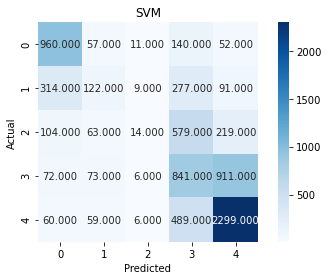

In [83]:
#Svm for float dataset
#Try to find the best kernel
classifier = SVC(kernel = 'linear')
classifier.fit(SVM_x_train_scaled,SVM_y_train.values.ravel())
SVM_y_pred = classifier.predict(SVM_x_val_scaled)

conf_matrix = metrics.confusion_matrix(SVM_y_val,SVM_y_pred) 
sns.heatmap(conf_matrix,annot=True,fmt=".3f",square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('SVM') 
plt.tight_layout()

In [84]:
accuracy = metrics.accuracy_score(SVM_y_val,SVM_y_pred)
error = 1 - accuracy
precision = metrics.precision_score(SVM_y_val,SVM_y_pred,average = None)
recall = metrics.recall_score(SVM_y_val,SVM_y_pred,average=None)
F1_score = metrics.f1_score(SVM_y_val,SVM_y_pred,average = None)
print(["accuracy:",accuracy,"error:",error, "precision:", precision,"recall:",recall,"F1_score",F1_score])

['accuracy:', 0.541134389371487, 'error:', 0.45886561062851305, 'precision:', array([0.63576159, 0.32620321, 0.30434783, 0.36156492, 0.64361702]), 'recall:', array([0.78688525, 0.1500615 , 0.01430031, 0.44193379, 0.78922073]), 'F1_score', array([0.7032967 , 0.20556024, 0.02731707, 0.39772996, 0.70902082])]


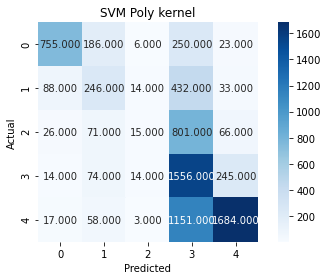

In [85]:
classifier = SVC(kernel = 'poly')
classifier.fit(SVM_x_train_scaled,SVM_y_train.values.ravel())
SVM_y_pred = classifier.predict(SVM_x_val_scaled)
conf_matrix = metrics.confusion_matrix(SVM_y_val,SVM_y_pred)
sns.heatmap(conf_matrix,annot=True,fmt=".3f",square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('SVM Poly kernel')
plt.tight_layout()

In [86]:
accuracy = metrics.accuracy_score(SVM_y_val,SVM_y_pred)
error = 1 - accuracy
precision = metrics.precision_score(SVM_y_val,SVM_y_pred,average = None)
recall = metrics.recall_score(SVM_y_val,SVM_y_pred,average=None)
F1_score = metrics.f1_score(SVM_y_val,SVM_y_pred,average = None)
print(["accuracy:",accuracy,"error:",error, "precision:", precision,"recall:",recall,"F1_score",F1_score])

['accuracy:', 0.5436893203883495, 'error:', 0.4563106796116505, 'precision:', array([0.83888889, 0.38740157, 0.28846154, 0.37136038, 0.8210629 ]), 'recall:', array([0.61885246, 0.30258303, 0.01532176, 0.81765633, 0.57809818]), 'F1_score', array([0.71226415, 0.33977901, 0.02909796, 0.51075004, 0.67848509])]


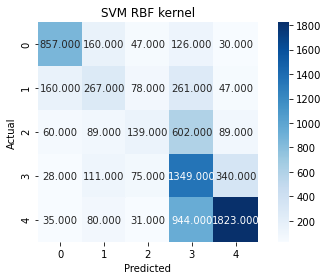

In [87]:
classifier = SVC(kernel = 'rbf')
classifier.fit(SVM_x_train_scaled,SVM_y_train.values.ravel())
SVM_y_pred = classifier.predict(SVM_x_val_scaled)
conf_matrix = metrics.confusion_matrix(SVM_y_val,SVM_y_pred)
sns.heatmap(conf_matrix,annot=True,fmt=".3f",square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('SVM RBF kernel')
plt.tight_layout()

In [88]:
accuracy = metrics.accuracy_score(SVM_y_val,SVM_y_pred)
error = 1 - accuracy
precision = metrics.precision_score(SVM_y_val,SVM_y_pred,average = None)
recall = metrics.recall_score(SVM_y_val,SVM_y_pred,average=None)
F1_score = metrics.f1_score(SVM_y_val,SVM_y_pred,average = None)
print(["accuracy:",accuracy,"error:",error, "precision:", precision,"recall:",recall,"F1_score",F1_score])

['accuracy:', 0.5665559529892693, 'error:', 0.4334440470107307, 'precision:', array([0.75175439, 0.37765205, 0.37567568, 0.41102986, 0.78273937]), 'recall:', array([0.70245902, 0.32841328, 0.14198161, 0.70888071, 0.62581531]), 'F1_score', array([0.72627119, 0.35131579, 0.20607858, 0.52034716, 0.69553605])]


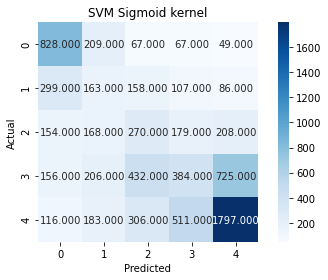

In [89]:
classifier = SVC(kernel = 'sigmoid')
classifier.fit(SVM_x_train_scaled,SVM_y_train.values.ravel())
SVM_y_pred = classifier.predict(SVM_x_val_scaled)
conf_matrix = metrics.confusion_matrix(SVM_y_val,SVM_y_pred)
sns.heatmap(conf_matrix,annot=True,fmt=".3f",square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('SVM Sigmoid kernel')
plt.tight_layout()

In [90]:
accuracy = metrics.accuracy_score(SVM_y_val,SVM_y_pred)
error = 1 - accuracy
precision = metrics.precision_score(SVM_y_val,SVM_y_pred,average = None)
recall = metrics.recall_score(SVM_y_val,SVM_y_pred,average=None)
F1_score = metrics.f1_score(SVM_y_val,SVM_y_pred,average = None)
print(["accuracy:",accuracy,"error:",error, "precision:", precision,"recall:",recall,"F1_score",F1_score])

['accuracy:', 0.43970362800204393, 'error:', 0.5602963719979561, 'precision:', array([0.53316162, 0.17545748, 0.2189781 , 0.30769231, 0.62722513]), 'recall:', array([0.67868852, 0.200492  , 0.27579162, 0.20178665, 0.6168898 ]), 'F1_score', array([0.59718716, 0.18714122, 0.24412297, 0.24373215, 0.62201454])]


In [91]:
rmse = np.sqrt(mean_squared_error(SVM_y_val, SVM_y_pred))
mae = mean_absolute_error(SVM_y_val, SVM_y_pred)
print("Mean Baseline Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

Mean Baseline Test set metrics:
	root_mean_square_error =  1.3345091477033932
	mean_absolute_error =  0.8831119059785386


In [92]:
rmse = np.sqrt(mean_squared_error(SVM_y_val, SVM_y_pred))
mae = mean_absolute_error(SVM_y_val, SVM_y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)


Model Test set metrics:
	root_mean_square_error =  1.3345091477033932
	mean_absolute_error =  0.8831119059785386


In [93]:
#Implementation of the HinSAGE by changing the number of you can try increasing the number of training epochs,
#change the dropout rate, change the sample sizes for subgraph sampling num_samples, hidden layer sizes 
#layer_sizes of the HinSAGE part of the model, or try increasing the number of HinSAGE layers.

#Case 1
# Increase layer size


In [94]:
num_samples_2 = [8, 4]

In [95]:
hinsage_layer_sizes_2 = [52, 52]
assert len(hinsage_layer_sizes_2) == len(num_samples_2)

hinsage_2 = HinSAGE(
    layer_sizes=hinsage_layer_sizes_2, generator=generator, bias=True, dropout=0.0
)

In [96]:
x_inp_2, x_out_2 = hinsage_2.in_out_tensors()

In [97]:
score_prediction_2 = link_regression(edge_embedding_method="concat")(x_out_2)

link_regression: using 'concat' method to combine node embeddings into edge embeddings


In [100]:
model_2 = Model(inputs=x_inp_2, outputs=score_prediction_2)
model_2.compile(
    optimizer=optimizers.Adam(lr=1e-2),
    loss=losses.mean_squared_error,
    metrics=[root_mean_square_error, metrics.mae],
)

In [101]:
model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 8, 1)]       0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 32, 1)]      0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 32, 1)]      0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1, 1)]       0                                            
____________________________________________________________________________________________

In [102]:
num_workers = 4

In [103]:
test_metrics_2 = model_2.evaluate(
    test_gen, verbose=1, use_multiprocessing=False, workers=num_workers
)

print("Untrained model's Test Evaluation:")
for name, val in zip(model_2.metrics_names, test_metrics_2):
    print("\t{}: {:0.4f}".format(name, val))

59/59 [==============================] - 20s 304ms/step - loss: 14.0631 - root_mean_square_error: 3.7493 - mean_absolute_error: 3.46023s - loss: 14.0478 - root_mean_square_error: 3.7471 - mean_absolute_error: 3.4 - ETA: 2s - loss: 14.0572 - root_mean_square_error: 3.7484 - mean_absolute_error - ETA: 16s - loss: 14.0616 - root_mean_square_error: 3.7490 - mean_absolute_err - ETA: 10s - loss: 14.0643 - root_mean_square_error: 3.7494 - mean_absolut
Untrained model's Test Evaluation:
	loss: 14.0670
	root_mean_square_error: 3.7503
	mean_absolute_error: 3.4602


In [104]:
history_2 = model_2.fit(
    train_gen,
    validation_data=test_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    workers=num_workers,
)

Epoch 1/20
137/137 [==============================] - 22s 120ms/step - loss: 2.0385 - root_mean_square_error: 1.3761 - mean_absolute_error: 1.1848 - val_loss: 0.9348 - val_root_mean_square_error: 0.9650 - val_mean_absolute_error: 0.70886339 - root_mean_square_error: 1.8178 - mean_absolute_error:  - ETA: 12s - loss: 3.3562 - root_mean_square_error: 1.7530 - mean_absolute_e - ETA: 9s - loss: 2.9731 - root_mean_square_error: 1.6566 - m - ETA: 6s - loss: 2.7241 - root_mean_square_error: 1.5930 - mean_absolute_error: 1.39 - ETA: 6s - loss: 2.7130 - root_mean_square_error: 1.5902 - mean_absolute_error: 1. - ETA: 6s - loss: 2.6904 - root_mean_ - ETA: 3s - loss: 2.3582 - root_mean_square_error: 1.4887 - mean_abso - ETA: 2s - loss: 2.2555 - root_mean_square_error: 1.4548 - mea
Epoch 2/20
137/137 [==============================] - 18s 132ms/step - loss: 0.8820 - root_mean_square_error: 0.9370 - mean_absolute_error: 0.6940 - val_loss: 0.8203 - val_root_mean_square_error: 0.9038 - val_mean_absolut

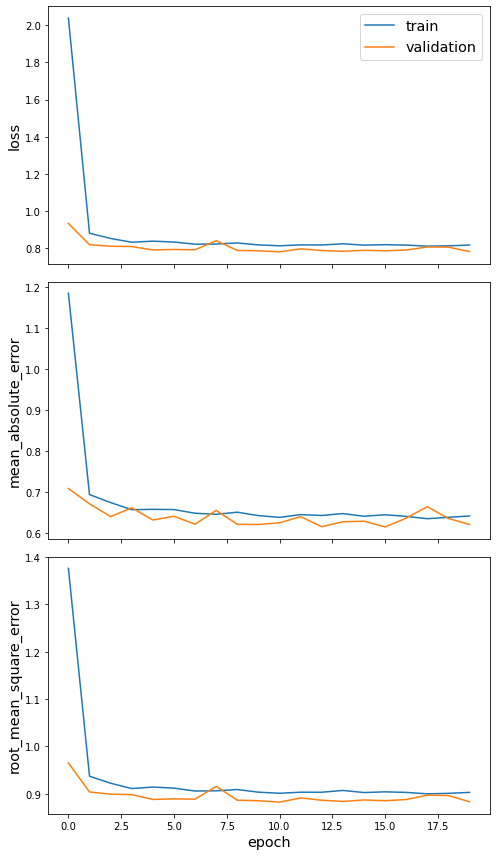

In [105]:
sg.utils.plot_history(history_2)

In [106]:
test_metrics_2 = model_2.evaluate(
    test_gen, use_multiprocessing=False, workers=num_workers, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model_2.metrics_names, test_metrics_2):
    print("\t{}: {:0.4f}".format(name, val))

59/59 [==============================] - 5s 68ms/step - loss: 0.7853 - root_mean_square_error: 0.8841 - mean_absolute_error: 0.6216 3s - loss: 0.7908 - root_mean_
Test Evaluation:
	loss: 0.7853
	root_mean_square_error: 0.8841
	mean_absolute_error: 0.6216


In [107]:
y_true = labels_test
# Predict the rankings using the model:
y_pred = model_2.predict(test_gen)
# Mean baseline rankings = mean movie ranking:
y_pred_baseline = np.full_like(y_pred, np.mean(y_true))

rmse = np.sqrt(mean_squared_error(y_true, y_pred_baseline))
mae = mean_absolute_error(y_true, y_pred_baseline)
print("Mean Baseline Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

Mean Baseline Test set metrics:
	root_mean_square_error =  1.4579314691033447
	mean_absolute_error =  1.2689980468074258

Model Test set metrics:
	root_mean_square_error =  0.887315238313062
	mean_absolute_error =  0.6225205410498408


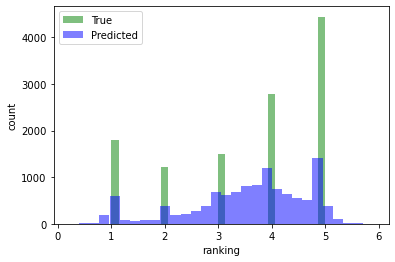

In [108]:
h_true = plt.hist(y_true, bins=30, facecolor="green", alpha=0.5)
h_pred = plt.hist(y_pred, bins=30, facecolor="blue", alpha=0.5)
plt.xlabel("ranking")
plt.ylabel("count")
plt.legend(("True", "Predicted"))
plt.show()

In [109]:
# Case 2

#Case 1
#1 increase epochs
#2 change dropout rate
#3 change num_samples,hidden layer sizer(layer_sizes)

In [110]:
epochs_3 = 30

In [111]:
num_samples_3 = [12, 8]

In [112]:
generator_3 = HinSAGELinkGenerator(
    G, batch_size, num_samples_3, head_node_types=["user", "business"]
)
train_gen_3 = generator_3.flow(edgelist_train, labels_train, shuffle=True)
test_gen_3 = generator_3.flow(edgelist_test, labels_test)

In [113]:
generator_3.schema.type_adjacency_list(generator_3.head_node_types, len(num_samples_3))

[('user', [2]),
 ('business', [3]),
 ('business', [4]),
 ('user', [5]),
 ('user', []),
 ('business', [])]

In [114]:
generator_3.schema.schema

{'user': [EdgeType(n1='user', rel='default', n2='business')],
 'business': [EdgeType(n1='business', rel='default', n2='user')]}

In [115]:
hinsage_layer_sizes_3 = [52, 52]
assert len(hinsage_layer_sizes_3) == len(num_samples_3)

hinsage_3 = HinSAGE(
    layer_sizes=hinsage_layer_sizes_3, generator=generator_3, bias=True, dropout=0.2
)

In [116]:
x_inp_3, x_out_3 = hinsage_3.in_out_tensors()

In [117]:
score_prediction_3 = link_regression(edge_embedding_method="concat")(x_out_3)

link_regression: using 'concat' method to combine node embeddings into edge embeddings


In [118]:
model_3 = Model(inputs=x_inp_3, outputs=score_prediction_3)
model_3.compile(
    optimizer=optimizers.Adam(lr=1e-2),
    loss=losses.mean_squared_error,
    metrics=[root_mean_square_error, metrics.mae],
)

In [119]:
model_3.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 12, 1)]      0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 96, 1)]      0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 96, 1)]      0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 1, 1)]       0                                            
____________________________________________________________________________________________

In [120]:
num_workers_3 = 4

In [121]:
test_metrics_3 = model_3.evaluate(
    test_gen_3, verbose=1, use_multiprocessing=False, workers=num_workers
)

print("Untrained model's Test Evaluation:")
for name, val in zip(model_3.metrics_names, test_metrics_3):
    print("\t{}: {:0.4f}".format(name, val))

59/59 [==============================] - 17s 216ms/step - loss: 13.0374 - root_mean_square_error: 3.6099 - mean_absolute_error: 3.308115s - loss: 13.0200 - root_mean_square_erro - ETA: 5s - loss: 13.0379 - root_mean_square_error: 3.6099 - mean_absolute_error: 3.3 - ETA: 5s - loss: 13.0370 - root_mean_square_error: 3.6098 - mean_absolute_error:  - ETA: 3s - loss: 13.0332 - root_mean_square_error: 3.6093 - mean_absolute_error: 3.
Untrained model's Test Evaluation:
	loss: 13.0422
	root_mean_square_error: 3.6111
	mean_absolute_error: 3.3082


In [122]:
history_3 = model_3.fit(
    train_gen_3,
    validation_data=test_gen_3,
    epochs=epochs_3,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    workers=num_workers_3,
)

Epoch 1/30
137/137 [==============================] - 59s 364ms/step - loss: 2.3028 - root_mean_square_error: 1.4863 - mean_absolute_error: 1.2857 - val_loss: 1.5272 - val_root_mean_square_error: 1.2352 - val_mean_absolute_error: 1.07937s - loss: 7.0845 - root_mean_square_error: 2.6052 - mean_absolute_error: 2.30 - ETA: 43s - loss: 6.3350 - root_mean_square_error: 2.4535 - mean_absolute_error: 2.183 - ETA: 43s - loss: 6.0403 - root_mean_square_error: 2.3922 - mean_absolute_error: 2.1 - ETA: 41s - loss: 5.2777 - root_mean_square_error: 2.2216 - mean_absolute_error: 1. - ETA: 37s - loss: 4.6111 - root_mean_square_error: 2.0667 - mean_absolute_error: 1 - ETA: 33s - loss: 4.0458 - root_mean_square_error: 1.9281 - mean_absolute_erro - ETA: 34s - loss: 3.4973 - root_mean_square_error: 1.7944 - mean_absolute_error: 1.57 - ETA: 33s - loss: 3.4188 - root_mean_square_error: 1.7756 - mean_absolu - ETA: 25s - loss: 2.9755 - root_mean_square_error: 1.6642 - mean_absolute_erro - ETA: 22s - loss: 2.8

137/137 [==============================] - 47s 342ms/step - loss: 1.3270 - root_mean_square_error: 1.1507 - mean_absolute_error: 0.9041 - val_loss: 1.7985 - val_root_mean_square_error: 1.3393 - val_mean_absolute_error: 1.1386: 1.3162 - root_mean_square_error: 1.1459 - mean_absolute_error: 0.90 - ETA: 25s - loss: 1.3234 - root_mean_square_error: 1.1490 - mean_absolute_error: - ETA: 23s - loss: 1.3215 - root_mean_square_error: 1.1481 - mean_absolute_error: 0. - ETA: 22s - loss: 1.3345 - root_mean_square_error: 1.1536 - mean_absolute_error: 0. - ETA: 21s - loss: 1.3345 - root_mean_square_error: 1.1537 - mean_absolute_error: 0.90 - ETA: 21s - loss: 1.3338 - root_mean_square_error: 1.1535 - mean_absolute_erro - ETA: 18s - loss: 1.3289 - root_mean_square_error: 1.1513 - mean_absolute_er - ETA: 15s - loss: 1.3259 - root_mean_square_error: 1.1502 - mean_absol - ETA: 11s - loss: 1.3263 - root_mean_square - ETA: 4s - loss: 1.3240 - root_mean_square_error: 1.1494 - mean_absolute_error: 0.90 - ETA

137/137 [==============================] - 46s 334ms/step - loss: 1.3130 - root_mean_square_error: 1.1444 - mean_absolute_error: 0.8933 - val_loss: 2.2722 - val_root_mean_square_error: 1.5060 - val_mean_absolute_error: 1.31311s - loss: 1.3301 - root_mean_square_error: 1.1519 - mean_absolute_e - ETA: 25s - loss: 1.3271 - root_mean_square_error: 1.1503 - mean_absolute_error:  - ETA: 23s - loss: 1.3256 - root_mean_square_error: 1.1497 - mean_absolute_error:  - ETA: 22s - loss: 1.3192 - root_mean_square_error: 1.1470 - mean_absolute_error: 0.894 - ETA: 22s - loss: 1.3166 - root_mean_square_error: 1.1459 - mean_absolute_error: 0.894 - ETA: 21s - loss: 1.3175 - root_mean_square_error: 1.1463 - mean_absolute_error: - ETA: 19s - loss: 1.3078 - root_mean_square_error: 1.1421 - mean_absolute_error: 0 - ETA: 18s - loss: 1.3145 - root_mean_square_error: 1.1450 - mean_absolute_error - ETA: 15s - loss: 1.3209 - root_mean_square_error: 1.1478 - mean_absolute_error: 0. - ETA: 14s - loss: 1.3218 - root

137/137 [==============================] - 46s 329ms/step - loss: 1.3149 - root_mean_square_error: 1.1449 - mean_absolute_error: 0.8975 - val_loss: 1.7155 - val_root_mean_square_error: 1.3083 - val_mean_absolute_error: 1.1349t_mean_square_error: 1.1396 - mean_absolute_error: 0 - ETA: 22s - loss: 1.3109 - root_mean_square_error: 1.1434 - mean_absolute_error: 0.89 - ETA: 21s - loss: 1.3063 - root_mean_square_error: 1.1414 - mean_absol - ETA: 17s - loss: 1.3286 - root_mean_square_error: 1.1508 - mean_absolute_error: 0.90 -  - ETA: 3s - loss: 1.3246 - root_mean_square_error: 1.1493 - mean_absolute_e
Epoch 22/30
137/137 [==============================] - 43s 305ms/step - loss: 1.2997 - root_mean_square_error: 1.1384 - mean_absolute_error: 0.8892 - val_loss: 1.9894 - val_root_mean_square_error: 1.4091 - val_mean_absolute_error: 1.22489s - loss: 1.3356 - root_mean_square_error: 1.1542 - ETA: 18s - loss: 1.3201 - root_mean_square_error: 1.1472 - mean_absolute_error: 0.89 - ETA: 18s - loss: 1.3

137/137 [==============================] - 44s 317ms/step - loss: 1.2916 - root_mean_square_error: 1.1348 - mean_absolute_error: 0.8833 - val_loss: 1.9862 - val_root_mean_square_error: 1.4079 - val_mean_absolute_error: 1.21739s - loss: 1.3149 - root_mean_square_error: 1.1448 - mean_absolu - ETA: 24s - loss: 1.3032 - root_mean_square_error: 1.1392 - mean_absolute_err - ETA: 21s - loss: 1.3047 - root_mean_square_error: 1.1400 - mean_absolute - ETA: 17s - loss: 1.3098 - root_mean_square_error: 1.1426 - mean_absolute_error: 0 - ETA: 16s - loss: 1.3182 - root_mean_square_error: 1.1463 - mean_absolute_err - ETA: 13s - loss: 1.3051 - root_mean_squa - ETA: 6s - loss: 1.2932 - root_mean_square_error: 1.1355 - mean_absolute - ETA: 5s - loss: 1.2900 - root_mean_square_error: 1.1341


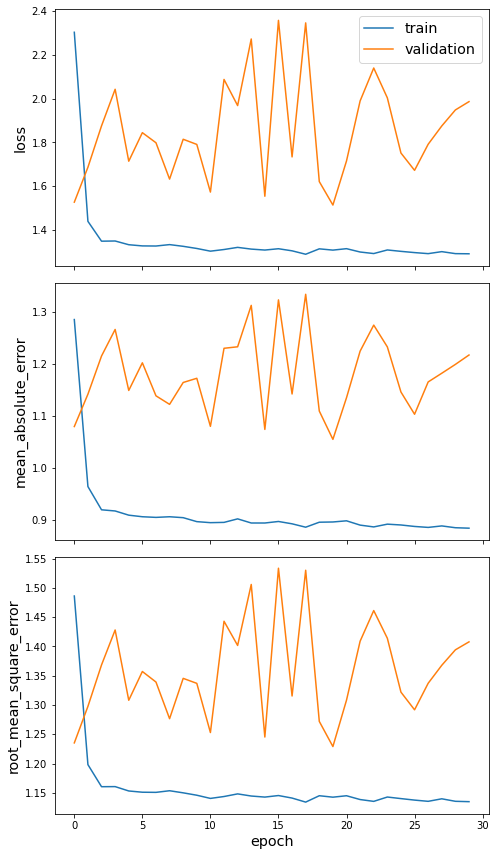

In [123]:
sg.utils.plot_history(history_3)

In [124]:
test_metrics_3 = model_3.evaluate(
    test_gen_3, use_multiprocessing=False, workers=num_workers_3, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model_3.metrics_names, test_metrics_3):
    print("\t{}: {:0.4f}".format(name, val))

59/59 [==============================] - 14s 225ms/step - loss: 1.9850 - root_mean_square_error: 1.4075 - mean_absolute_error: 1.2170 19s - loss: 1.9183 - root_mean_square_error: 1.3848 - mean_absolute_error: 1.2 - ETA: 20s - loss: 1.9331 - root_mean_square_error: 1.3902 - mean_ab - ETA: 8s - loss: 1.9854 - root_mean_square_error: 1. - ETA: 4s - loss: 1.9658 - root_mean_square_error: 1.4011 - mean_absolute_err - ETA: 3s - loss: 1.9810 - root_mean_square_error: 1.4063 - mean_absolute_error: 1.
Test Evaluation:
	loss: 1.9850
	root_mean_square_error: 1.4075
	mean_absolute_error: 1.2170


In [125]:
y_true = labels_test
# Predict the rankings using the model:
y_pred = model_3.predict(test_gen_3)
# Mean baseline rankings = mean movie ranking:
y_pred_baseline = np.full_like(y_pred, np.mean(y_true))

rmse = np.sqrt(mean_squared_error(y_true, y_pred_baseline))
mae = mean_absolute_error(y_true, y_pred_baseline)
print("Mean Baseline Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

Mean Baseline Test set metrics:
	root_mean_square_error =  1.4579314691033447
	mean_absolute_error =  1.2689980468074258

Model Test set metrics:
	root_mean_square_error =  1.4086534825930828
	mean_absolute_error =  1.216063865327364


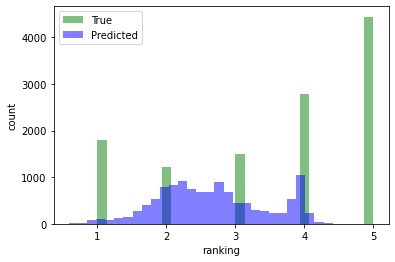

In [126]:
h_true = plt.hist(y_true, bins=30, facecolor="green", alpha=0.5)
h_pred = plt.hist(y_pred, bins=30, facecolor="blue", alpha=0.5)
plt.xlabel("ranking")
plt.ylabel("count")
plt.legend(("True", "Predicted"))
plt.show()

In [127]:
walk_length = 100  # maximum length of a random walk to use throughout this notebook

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["business", "user", "business"],
    ["user", "business", "business", "user"],
    ["business", "business"],
]

In [128]:
from stellargraph.data import UniformRandomMetaPathWalk

# Create the random walker
rw = UniformRandomMetaPathWalk(G)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=1,  # number of random walks per root node
    metapaths=metapaths,  # the metapaths
)

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 16098


In [129]:
from gensim.models import Word2Vec

model = Word2Vec(walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

In [130]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(15381, 128)

In [131]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [G.node_type(node_id) for node_id in node_ids]

In [132]:
from sklearn.manifold import TSNE
transform = TSNE  # PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

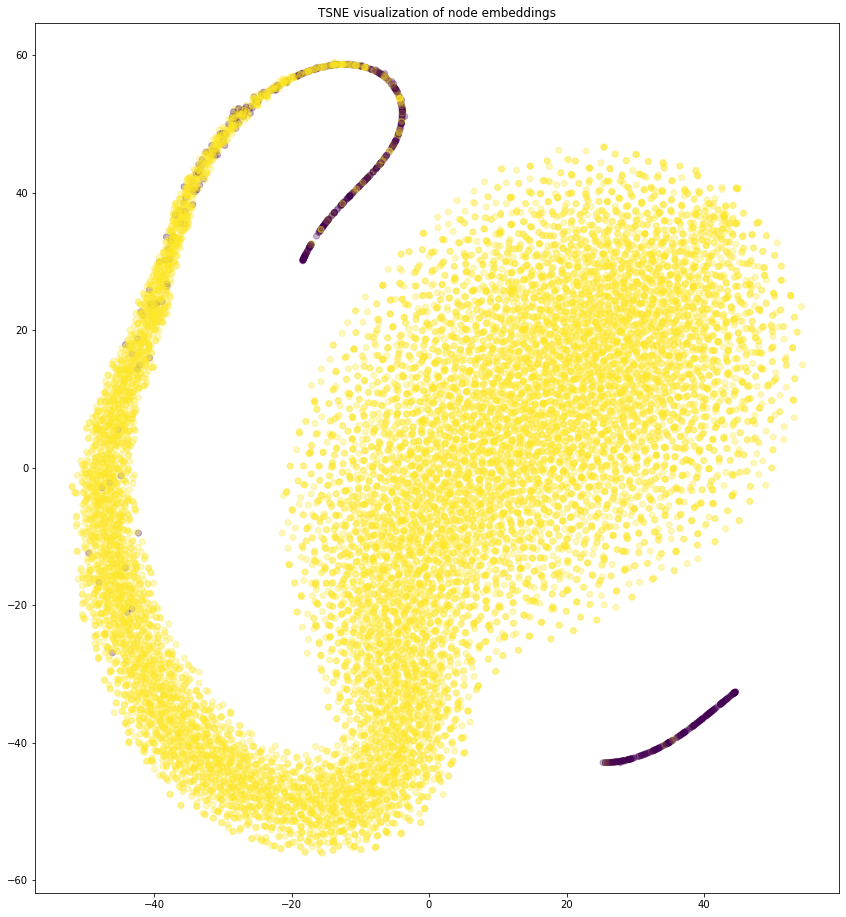

In [133]:
# draw the points
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(20, 16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=node_colours, alpha=0.3)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()

In [134]:
metapaths = [ ["user", "business", "user"],
    ["user", "business", "user", "user"],
    ["user", "user"],]

In [135]:
from stellargraph.data import UniformRandomMetaPathWalk

# Create the random walker
rw = UniformRandomMetaPathWalk(G)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=1,  # number of random walks per root node
    metapaths=metapaths,  # the metapaths
)

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 43992


In [136]:
from gensim.models import Word2Vec

model = Word2Vec(walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

In [137]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(15381, 128)

In [138]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [G.node_type(node_id) for node_id in node_ids]

In [139]:
from sklearn.manifold import TSNE
transform = TSNE  # PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

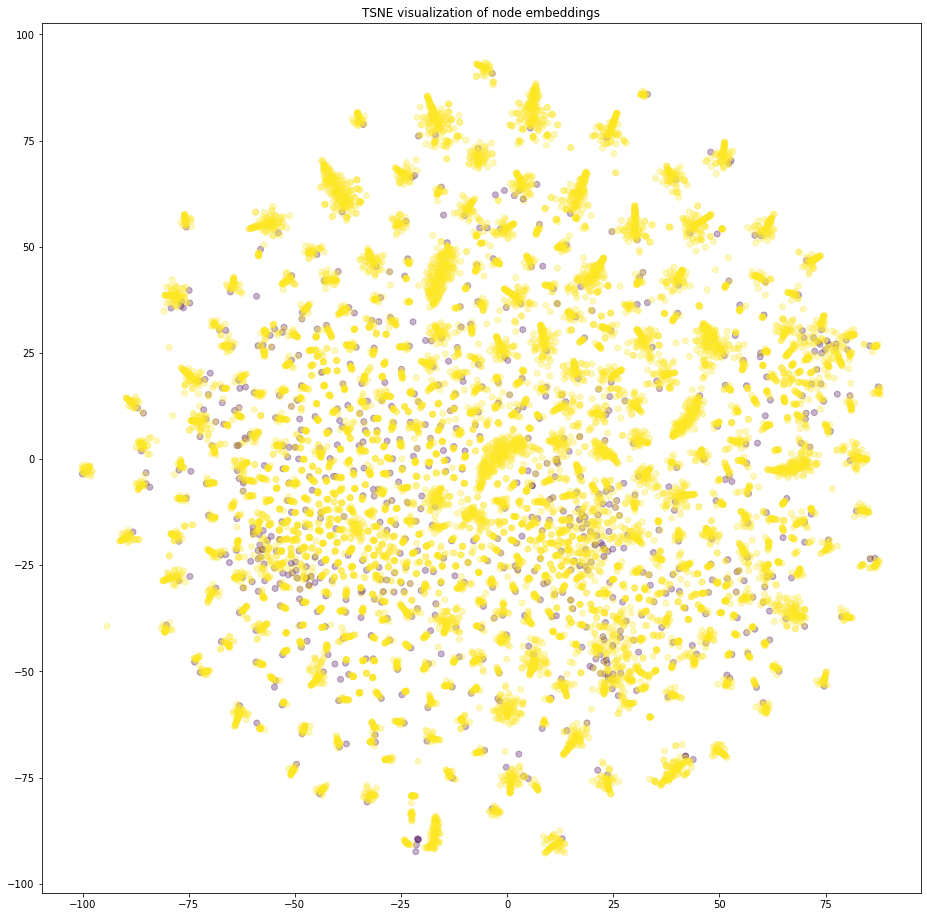

In [140]:
# draw the points
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(20, 16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=node_colours, alpha=0.3)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()